In [1]:
import re
import requests
import pandas as pd
from pandas import json_normalize
import numpy as np
import json
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords

In [2]:
# Initialize dataframe
show_df = pd.DataFrame(columns = ['show_id', 'name', 'genre', 'summary', 'airdate', 'country'])
show_df

,show_id,name,genre,summary,airdate,country


In [3]:
# Create count dict and initialize a date list and data container
country_dict = {'USA':'US', 'Canada':'CA', 'UK':'GB', 'Australia':'AU'}
date_range = []
scrape_data = []

# Pass 7 day range from specified years into date list
for year in range (2021, 2006, -1):
    for day in range(1,8):
        date = f'{year}-09-0{day}'
        date_range.append(date)

# Scrape tv show data from 'https://www.tvmaze.com/api'
for country, code in country_dict.items():
    for date in date_range:
        
        r = requests.get(f'https://api.tvmaze.com/schedule?country={code}&date={date}')
        content = json.loads(r.content)
        c = content
                
        for i in range(len(c)):
            if c[i]['show']['genres'] == []:
                continue
            show_data = pd.DataFrame({'show_id':[c[i]['show']['id']], 'name':[c[i]['show']['name']], 
                                      'all_genres':[c[i]['show']['genres']], 'summary':[c[i]['show']['summary']], 
                                      'airdate':date, 'country':country})
            scrape_data.append(show_data)

In [4]:
# Compile tv show dataframe
show_df = pd.concat([*scrape_data, show_df], ignore_index=True)
# Remove duplicate shows by Show_ID
show_df = show_df.drop_duplicates(subset=['show_id'], keep='first')

# Make new genre column for primary genre
show_df['genre'] = show_df.apply(lambda row: row['all_genres'][0],axis=1)
# Convert all_genres to string for processing
show_df['genre_string'] = [','.join(map(str, l)) for l in show_df['all_genres']]

print(show_df.shape)
show_df.head(3)

(2298, 8)


,show_id,name,all_genres,summary,airdate,country,genre,genre_string
0,2831,The Late Late Show with James Corden,"[Comedy, Music]","<p>Each week night, <b>The Late Late Show with...",2021-09-01,USA,Comedy,"Comedy,Music"
1,17546,Poker After Dark,[Sports],"<p>On <b>Poker After Dark</b>, professional po...",2021-09-01,USA,Sports,Sports
2,44660,The Bump,[Sports],<p>WWE's <b>The Bump</b> is unlike any WWE sho...,2021-09-01,USA,Sports,Sports


In [5]:
# Review unique genres for clustering
show_df.genre.unique()

array(['Comedy', 'Sports', 'Drama', 'Family', 'Adult', 'Action', 'Food',
       'Music', 'Mystery', 'Romance', 'Medical', 'Adventure', 'DIY',
       'History', 'Crime', 'Horror', 'Children', 'Nature', 'Supernatural',
       'Travel', 'Legal', 'Thriller', 'Science-Fiction', 'Fantasy',
       'Anime', 'War'], dtype=object)

In [6]:
# Find genres that are most commonly grouped together
genre_groups = show_df.groupby('genre_string').count()
genre_groups = genre_groups.sort_values(by='all_genres', ascending=False)

genre_groups['all_genres'].head(20)

genre_string
Comedy                     293
Food                       178
Crime                      116
Sports                      94
Drama                       80
Nature                      72
DIY                         70
Drama,Crime                 59
Music                       59
Children                    56
History                     51
Action,Adventure,Nature     49
Romance                     47
Food,Travel                 46
Medical                     43
Drama,Comedy                36
Drama,Romance               36
Travel                      34
Comedy,Family               31
Drama,Crime,Thriller        28
Name: all_genres, dtype: int64

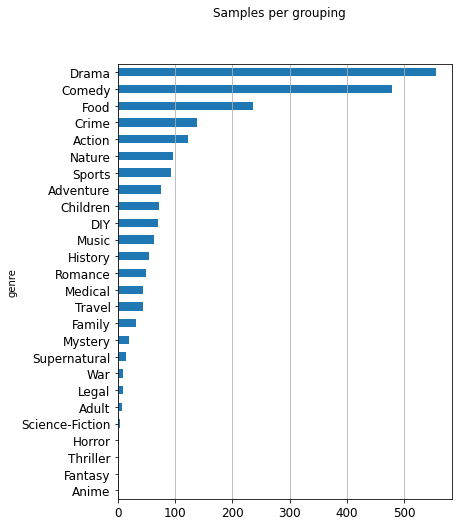

In [7]:
import matplotlib.pyplot as plt
# Visualize group sizes
fig, ax = plt.subplots(figsize=(6,8))
fig.suptitle('Samples per grouping', fontsize=12)
show_df['genre'].reset_index().groupby('genre').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax, fontsize=12).grid(axis='x')
plt.show()

In [8]:
# Drop redundant columns
show_df = show_df.drop(['all_genres','genre_string'], axis=1)

#Re-map tv show genres according to results above
show_df['genre'] = show_df['genre'].map({'Medical':'Drama', 'Crime':'Drama', 'Drama':'Drama', 'Romance':'Drama',
                                         'Children':'Children', 'Comedy':'Comedy', 'Family':'Comedy', 'Action':'Action', 
                                         'Adventure':'Action', 'Nature':'Action', 'DIY':'DIY', 'Sports':'Sports',
                                         'Food':'Lifestyle', 'Travel':'Lifestyle', 'Adult':'Other', 'Music':'Music',
                                         'Horror':'Other', 'Supernatural':'Other', 'History':'Other', 'War':'Other', 
                                         'Thriller':'Other', 'Legal':'Other', 'Mystery':'Other', 'Science-Fiction':'Other',
                                        'Fantasy':'Other', 'Anime':'Other'})
print(show_df.shape)
show_df.head(3)

(2298, 6)


,show_id,name,summary,airdate,country,genre
0,2831,The Late Late Show with James Corden,"<p>Each week night, <b>The Late Late Show with...",2021-09-01,USA,Comedy
1,17546,Poker After Dark,"<p>On <b>Poker After Dark</b>, professional po...",2021-09-01,USA,Sports
2,44660,The Bump,<p>WWE's <b>The Bump</b> is unlike any WWE sho...,2021-09-01,USA,Sports


In [9]:
# Check for missed categories as 'nan'
show_df.genre.unique()

array(['Comedy', 'Sports', 'Drama', 'Other', 'Action', 'Lifestyle',
       'Music', 'DIY', 'Children'], dtype=object)

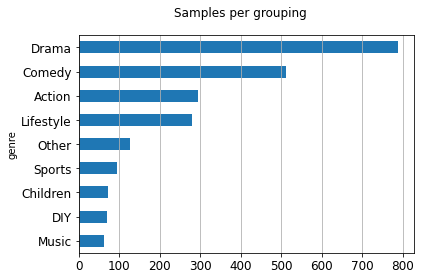

In [10]:
import matplotlib.pyplot as plt
# Visualize group sizes
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Samples per grouping', fontsize=12)
show_df['genre'].reset_index().groupby('genre').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax, fontsize=12).grid(axis='x')
plt.show()

In [11]:
# Text pre-processing
# Convert Summary data to type(str)
show_df['summary'] = show_df['summary'].apply(lambda x: str(x))
# Remove html tags and leading 'b's
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'<.*?>').sub(r' ',row))
# Remove special characters, replace with space
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'\W').sub(r' ',row))
# Remove single characters
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'\s+[a-zA-Z]\s+').sub(r' ',row))
# Remove stil characters from start
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'\^[a-zA-Z]\s+').sub(r' ',row))
# Remove numbers from summaries
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'[0-9]').sub(r' ',row))
# Clean up multi-space gaps
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'\s+').sub(r' ',row))
# Converting to lower case
show_df['summary'] = show_df['summary'].apply(lambda row: row.lower())


show_df

,show_id,name,summary,airdate,country,genre
0,2831,The Late Late Show with James Corden,each week night the late late show with james...,2021-09-01,USA,Comedy
1,17546,Poker After Dark,on poker after dark professional poker player...,2021-09-01,USA,Sports
2,44660,The Bump,wwe the bump is unlike any wwe show you ve ev...,2021-09-01,USA,Sports
3,4344,The Young and the Restless,the young and the restless revolves around th...,2021-09-01,USA,Drama
4,812,Days of Our Lives,days of our lives is set in the fictitious mi...,2021-09-01,USA,Drama
...,...,...,...,...,...,...
6326,27372,RSPCA Animal Rescue,hosted by blue wiggle anthony field rspca ani...,2007-09-04,Australia,Action
6329,1374,McLeod's Daughters,the four female leads carry the heart of each...,2007-09-05,Australia,Drama
6330,7295,Thank God You're Here,each episode involves four celebrities walkin...,2007-09-05,Australia,Comedy
6332,1285,Summer Heights High,over one term documentary crew films the ever...,2007-09-05,Australia,Drama


In [12]:
# Stopword function
import nltk
from nltk.corpus import stopwords

def stopword(string):
    res = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(res)

# Apply stopwords func to Summaries
show_df['summary'] = show_df['summary'].apply(lambda text: stopword(text))
show_df.head()

,show_id,name,summary,airdate,country,genre
0,2831,The Late Late Show with James Corden,week night late late show james corden throws ...,2021-09-01,USA,Comedy
1,17546,Poker After Dark,poker dark professional poker players phil hel...,2021-09-01,USA,Sports
2,44660,The Bump,wwe bump unlike wwe show ever seen featuring d...,2021-09-01,USA,Sports
3,4344,The Young and the Restless,young restless revolves around rivalries roman...,2021-09-01,USA,Drama
4,812,Days of Our Lives,days lives set fictitious midwestern town sale...,2021-09-01,USA,Drama


In [13]:
# Initialize lemmatizer
from nltk.stem import WordNetLemmatizer

wl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
# Download and import tokenizer libraries
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

# Tokenize Summaries
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    res = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(res)

# Apply lemmatizer func to Summaries
show_df['summary'] = show_df['summary'].apply(lambda text: lemmatizer(text))
show_df.head()

,show_id,name,summary,airdate,country,genre
0,2831,The Late Late Show with James Corden,week night late late show jam corden throw ult...,2021-09-01,USA,Comedy
1,17546,Poker After Dark,poker dark professional poker player phil hell...,2021-09-01,USA,Sports
2,44660,The Bump,wwe bump unlike wwe show ever see feature dyna...,2021-09-01,USA,Sports
3,4344,The Young and the Restless,young restless revolve around rivalry romance ...,2021-09-01,USA,Drama
4,812,Days of Our Lives,day live set fictitious midwestern town salem ...,2021-09-01,USA,Drama


In [15]:
# Initialize tokenizer and tokenize summary data
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

show_df['tokens'] = show_df['summary'].apply(tokenizer.tokenize)
print(show_df.shape)
show_df.head()

(2298, 7)


,show_id,name,summary,airdate,country,genre,tokens
0,2831,The Late Late Show with James Corden,week night late late show jam corden throw ult...,2021-09-01,USA,Comedy,"[week, night, late, late, show, jam, corden, t..."
1,17546,Poker After Dark,poker dark professional poker player phil hell...,2021-09-01,USA,Sports,"[poker, dark, professional, poker, player, phi..."
2,44660,The Bump,wwe bump unlike wwe show ever see feature dyna...,2021-09-01,USA,Sports,"[wwe, bump, unlike, wwe, show, ever, see, feat..."
3,4344,The Young and the Restless,young restless revolve around rivalry romance ...,2021-09-01,USA,Drama,"[young, restless, revolve, around, rivalry, ro..."
4,812,Days of Our Lives,day live set fictitious midwestern town salem ...,2021-09-01,USA,Drama,"[day, live, set, fictitious, midwestern, town,..."


In [16]:
# Create token length count column
show_df['token_count'] = [len(x) for x in show_df['tokens']]

# Calculate standard deviation of token counts
pd.DataFrame.std(show_df.token_count, ddof=2)

28.63964745962698

In [17]:
show_df.head(3)

,show_id,name,summary,airdate,country,genre,tokens,token_count
0,2831,The Late Late Show with James Corden,week night late late show jam corden throw ult...,2021-09-01,USA,Comedy,"[week, night, late, late, show, jam, corden, t...",65
1,17546,Poker After Dark,poker dark professional poker player phil hell...,2021-09-01,USA,Sports,"[poker, dark, professional, poker, player, phi...",29
2,44660,The Bump,wwe bump unlike wwe show ever see feature dyna...,2021-09-01,USA,Sports,"[wwe, bump, unlike, wwe, show, ever, see, feat...",22


In [18]:
# !pip install keras
# !pip install tensorflow
import tensorflow
import keras
from keras.preprocessing.text import Tokenizer

all_words = [word for tokens in show_df['tokens'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in show_df['tokens']]
VOCAB = sorted(list(set(all_words)))
print(f'{len(all_words)} words total')
print(f'{len(VOCAB)} words in vocabulary')

92239 words total
13205 words in vocabulary


In [19]:
# Building a new dictionary with only statistically significant words
from sklearn import feature_extraction
from sklearn import feature_selection
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = feature_extraction.text.TfidfVectorizer(max_features=len(VOCAB), ngram_range=(1,2))

X = show_df['summary']
y = show_df['genre']
vectorizer.fit(X)

X = vectorizer.transform(X)
dict_vocabulary = vectorizer.vocabulary_

X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

# Initialize features df
show_df_features = pd.DataFrame()
# Keep only the feature that are statistically significant in predicting genre
for category in np.unique(y):
    chi2, p = feature_selection.chi2(X, y == category)
    show_df_features = show_df_features.append(pd.DataFrame({'feature':X_names, 'score':1-p, 'y':category}))
    show_df_features = show_df_features[show_df_features['score'] > p_value_limit]
    
X_names = show_df_features['feature'].unique().tolist()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
show_df_features.head()
# print(show_df_features.shape)

,feature,score,y
142,adventure,0.998741,Action
152,adventurer,0.997056,Action
167,africa,0.998753,Action
228,alaska,0.992542,Action
231,alaskan,0.994348,Action


In [21]:
# Top 10 statistically significant words per category
for category in np.unique(y):
    print(f'* {category}:')
    print('  - Statistically significant features:', 
         len(show_df_features[show_df_features['y'] == category]))
    print("  -", ", ".join(show_df_features[show_df_features['y'] == category]['feature'].values[:10]),'\n')

* Action:
  - Statistically significant features: 96
  - adventure, adventurer, africa, alaska, alaskan, andes, animal, animal remarkable, bear, bear grylls 

* Children:
  - Statistically significant features: 166
  - accessible, across canada, adventure, adventure series, air since, alien come, amazing world, animate, animate series, animated 

* Comedy:
  - Statistically significant features: 42
  - alex, animation, cast, celebrity, celebrity guest, clip, comedian, comedic, comedy, comedy series 

* DIY:
  - Statistically significant features: 259
  - affordable, alternative require, amaze, amaze new, amy matthew, anna richardson, appliance, attic, auction, automotive 

* Drama:
  - Statistically significant features: 53
  - adventure, bachelor, case, chef, comedy, commit, cook, cop, crime, crime series 

* Lifestyle:
  - Statistically significant features: 193
  - aarón, abroad, across america, adam richman, ainsley, alton, amateur, american picker, andrew, anthony 

* Music:
  - S

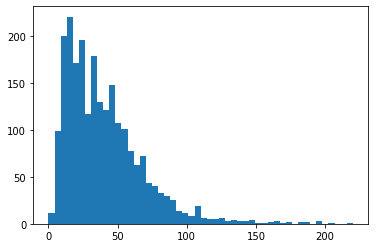

In [22]:
# Check for outlier data with histplot
import matplotlib.pyplot as plt
# plt.xticks(np.arange(0, 250, step=10))
plt.hist(sentence_lengths, bins=50);

In [23]:
# Drop outliers
show_df = show_df.drop(show_df[show_df.token_count <= 15].index)
show_df = show_df.drop(show_df[show_df.token_count > 100].index)
print(show_df.shape)
show_df.head()

(1801, 8)


,show_id,name,summary,airdate,country,genre,tokens,token_count
0,2831,The Late Late Show with James Corden,week night late late show jam corden throw ult...,2021-09-01,USA,Comedy,"[week, night, late, late, show, jam, corden, t...",65
1,17546,Poker After Dark,poker dark professional poker player phil hell...,2021-09-01,USA,Sports,"[poker, dark, professional, poker, player, phi...",29
2,44660,The Bump,wwe bump unlike wwe show ever see feature dyna...,2021-09-01,USA,Sports,"[wwe, bump, unlike, wwe, show, ever, see, feat...",22
3,4344,The Young and the Restless,young restless revolve around rivalry romance ...,2021-09-01,USA,Drama,"[young, restless, revolve, around, rivalry, ro...",44
4,812,Days of Our Lives,day live set fictitious midwestern town salem ...,2021-09-01,USA,Drama,"[day, live, set, fictitious, midwestern, town,...",22


In [24]:
''' Original model '''

' Original model '

In [25]:
import statsmodels.api as sm
import scipy as sc
import sklearn.feature_extraction.text as text
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import r2_score,fowlkes_mallows_score

# Keep only the 5,000 highest occurring words that do not appear in more than 70% of samples
tf = text.TfidfVectorizer(max_features=10000, max_df=0.7)#, vocabulary=X_names) # Add custom dictionary
# Convert df using TF-IDF features
X = tf.fit_transform(show_df['summary'])
y = show_df['genre']
# Initialize PCA with 500 components and fit X
pca = PCA(n_components=5)
X = pca.fit(X.todense().T).components_.T

# Create 9 clusters from data 
km = KMeans(n_clusters=9)
km.fit(X)
# Create predictions
y_pred = km.predict(X)
# Retrieve Fowlkes Mallows score
fowlkes_mallows_score(y, y_pred)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.2743602259223602

Text(0.5, 1.0, 'Elbow method')

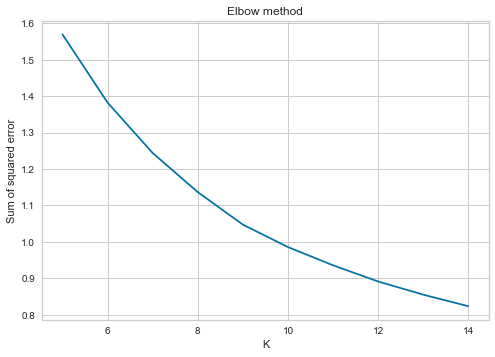

In [93]:
sse = []
k_rng = range(5,15)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

#plotting the 'elbow' graph
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)
plt.title('Elbow method')

In [92]:
!pip3 install numpy --upgrade


  Using cached numpy-1.21.4-cp39-cp39-macosx_10_9_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.


In [26]:
X

array([[ 0.02547498,  0.03410606,  0.07624438,  0.00940132, -0.01451846],
       [ 0.01638776,  0.01703941,  0.02315297, -0.00126371, -0.02055575],
       [ 0.01746086,  0.02091402,  0.04352792,  0.00723471, -0.00372725],
       ...,
       [ 0.02747056, -0.01541712,  0.02353862, -0.0008982 ,  0.00890235],
       [ 0.03107398,  0.01492821,  0.0304542 ,  0.00060359, -0.02259747],
       [ 0.01740839, -0.00979809, -0.00459002, -0.01885774,  0.02700882]])

In [27]:
#Elbow graph

In [28]:
show_df['y_pred'] = y_pred
show_df.groupby(y_pred).count()

,show_id,name,summary,airdate,country,genre,tokens,token_count,y_pred
0,73,73,73,73,73,73,73,73,73
1,506,506,506,506,506,506,506,506,506
2,290,290,290,290,290,290,290,290,290
3,213,213,213,213,213,213,213,213,213
4,57,57,57,57,57,57,57,57,57
5,131,131,131,131,131,131,131,131,131
6,127,127,127,127,127,127,127,127,127
7,103,103,103,103,103,103,103,103,103
8,301,301,301,301,301,301,301,301,301


In [55]:
show_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1801 entries, 0 to 6334
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_id      1801 non-null   object
 1   name         1801 non-null   object
 2   summary      1801 non-null   object
 3   airdate      1801 non-null   object
 4   country      1801 non-null   object
 5   genre        1801 non-null   object
 6   tokens       1801 non-null   object
 7   token_count  1801 non-null   int64 
 8   y_pred       1801 non-null   int32 
dtypes: int32(1), int64(1), object(7)
memory usage: 198.2+ KB


In [29]:
print(X.shape)
print(y_pred.shape)

(1801, 5)
(1801,)


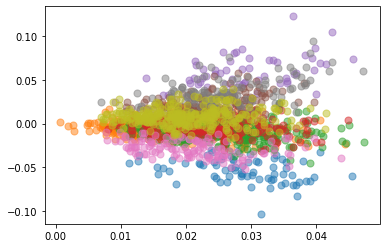

In [30]:
def get_plots(cluster_number):
    for i in range(cluster_number):
        plt.scatter(X[y_pred == i,0],X[y_pred == i,1], s=50, alpha=.5)
    plt.show()
    
get_plots(9)

/var/folders/3v/qs19pl4s4bl0h4lwglmmm9d80000gn/T/ipykernel_99901/3933375062.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


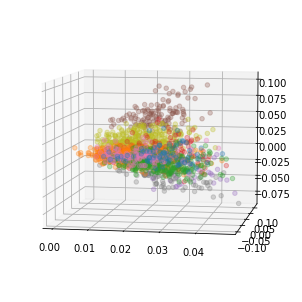

In [31]:
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for i in range(9):
    ax.scatter(X[y_pred == i,0],X[y_pred == i,1], X[y_pred == i, 2],alpha=0.3)
# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(45, angle)
#     plt.draw()
#     plt.pause(.001)

In [32]:
import plotly.graph_objects as go

fig = go.Figure()

for i in range(9):

    fig.add_trace(go.Scatter3d(x = X[y_pred == i,0],
                            y = X[y_pred == i,1],
                            z = X[y_pred == i, 2],
                            mode = 'markers', marker_size = 8, marker_line_width = 1,
                            name = 'Cluster ' + str(i)))
#X[y_pred == i,0],X[y_pred == i,1], X[y_pred == i, 2]
plt.show()#fig.show()
#fig.savefig('demo.png', bbox_inches='tight')

In [57]:
name_show = show_df['name'].to_list()
c_df['tv_show'] = name_show

In [42]:
c_df = pd.DataFrame(X)

In [65]:
c_df = pd.DataFrame(X)
c_df = c_df.iloc[:, : 3]
c_df.columns = 'x','y','z'
c_df['clusters'] = y_pred
genre_show = show_df['genre'].to_list()
c_df['genre'] = genre_show



name_show = show_df['name'].to_list()
c_df['tv_show'] = name_show
c_df.info()

df_0 = c_df[c_df['clusters'] == 0]
df_1 = c_df[c_df['clusters'] == 1]
df_2 = c_df[c_df['clusters'] == 2]
df_3 = c_df[c_df['clusters'] == 3]
df_4 = c_df[c_df['clusters'] == 4]
df_5 = c_df[c_df['clusters'] == 5]
df_6 = c_df[c_df['clusters'] == 6]
df_7 = c_df[c_df['clusters'] == 7]
df_8 = c_df[c_df['clusters'] == 8]

df_0.groupby('genre').count()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         1801 non-null   float64
 1   y         1801 non-null   float64
 2   z         1801 non-null   float64
 3   clusters  1801 non-null   int32  
 4   genre     1801 non-null   object 
 5   tv_show   1801 non-null   object 
dtypes: float64(3), int32(1), object(2)
memory usage: 77.5+ KB


In [ ]:
c_df['genre_pred'] = c_df['clusters'].map({})

In [61]:
import plotly.express as px

color_ = ['red','orange','blue','green','yellow','pink','purple','brown','black']
fig = px.scatter_3d(c_df,x='x',y='y',z='z',color='clusters')





In [71]:
df_0 = c_df[c_df['clusters'] == 0]
df_1 = c_df[c_df['clusters'] == 1]
df_2 = c_df[c_df['clusters'] == 2]
df_3 = c_df[c_df['clusters'] == 3]
df_4 = c_df[c_df['clusters'] == 4]
df_5 = c_df[c_df['clusters'] == 5]
df_6 = c_df[c_df['clusters'] == 6]
df_7 = c_df[c_df['clusters'] == 7]
df_8 = c_df[c_df['clusters'] == 8]

In [ ]:
#0 = 71 - drama
#1 = 194 - drama, 104 - comedy , 95 - action
#2 = 167 - drama, 77 - comedy, 11 - action
#3 = 101-  action, 40 drama, 13 lifestyle, other 39
#4 = 53 - lifestyle, 2 children
#5 = 82 comedy, 28 spoorts
#6 = 112 Drama, 10 other
#7 = 100 lifestyle
#8 = 125 Comedy, 50 Drama, 31 music


In [85]:
df_0.groupby('genre').count()

,x,y,z,clusters,tv_show
genre,,,,,
Action,1,1,1,1,1
Drama,71,71,71,71,71
Other,1,1,1,1,1


In [62]:
fig.show()

In [ ]:
!pip install nbformat

     |████████████████████████████████| 178 kB 4.5 MB/s            
     |████████████████████████████████| 69 kB 3.1 MB/s             
     |████████████████████████████████| 68 kB 7.5 MB/s             


In [ ]:
import plotly.plotly as py
import pandas as pd

for i in range(9):
    scatter = dict(
        mode = "markers",
        name = "y",
        type = "scatter3d",
        x = X[y_pred == i,0], y = X[y_pred == i,1], z = X[y_pred == i, 2],
        marker = dict( size=2, color="rgb(23, 190, 207)" )
    )
    clusters = dict(
        alphahull = 7,
        name = "y",
        opacity = 0.1,
        type = "mesh3d",
        x = X[y_pred == i,0], y = X[y_pred == i,1], z = X[y_pred == i, 2]
    )
    layout = dict(
        title = '3d point clustering',
        scene = dict(
            xaxis = dict( zeroline=False ),
            yaxis = dict( zeroline=False ),
            zaxis = dict( zeroline=False ),
        )
    )
    fig = dict( data=[scatter, clusters], layout=layout )
# Use py.iplot() for IPython notebook
py.iplot(fig, filename='3d point clustering')

ImportError: 
The plotly.plotly module is deprecated,
please install the chart-studio package and use the
chart_studio.plotly module instead. 


In [ ]:
show_df.head(3)

,show_id,name,summary,airdate,country,genre,tokens,token_count,y_pred,targets
0,2831,The Late Late Show with James Corden,week night late late show jam corden throw ult...,2021-09-01,USA,Comedy,"[week, night, late, late, show, jam, corden, t...",65,1,2
1,17546,Poker After Dark,poker dark professional poker player phil hell...,2021-09-01,USA,Sports,"[poker, dark, professional, poker, player, phi...",29,1,5
2,44660,The Bump,wwe bump unlike wwe show ever see feature dyna...,2021-09-01,USA,Sports,"[wwe, bump, unlike, wwe, show, ever, see, feat...",22,1,5


In [ ]:
# from scipy.stats import mode
# import statistics as st

show_df['targets'] = show_df['genre'].map({'Drama':0, 'Children':1, 'Comedy':2, 'Action':3, 'DIY':4, 'Sports':5,
                                         'Lifestyle':6, 'Other':7, 'Music':8})

# genre_list = ['Drama', 'Children', 'Comedy', 'Action', 'DIY', 'Sports', 'Lifestyle', 'Other', 'Music']

show_df['targets'] = show_df['targets'].astype(int)

targets = show_df['targets']

real_labels = np.zeros(y_pred.shape)
real_labels.shape

for i in range(9):
    is_value = y_pred == i
    real_labels[is_value] = st.mode(targets[is_value])

In [ ]:
is_value = y_pred == 4

In [ ]:
is_value.sum()

157

In [ ]:
targets[is_value]

11      6
21      6
26      6
47      6
48      6
       ..
6111    6
6114    6
6141    6
6146    6
6173    6
Name: targets, Length: 157, dtype: int32

In [ ]:
real_labels[is_value] = st.mode(targets[is_value])

In [ ]:
real_labels[:50]

array([2., 0., 2., 0., 0., 0., 0., 2., 0., 2., 0., 6., 0., 0., 0., 0., 0.,
       0., 0., 0., 6., 0., 0., 2., 0., 6., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 6., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])